<h2> Deep Neural network model to predict production line failures.
    
<h4> Dataset: Kaggle Bosch Data (over 1.2 Million rows, 900+ columns for numeric data alone)
    Huge class imbalance - defects are only 0.6% of the total data.
    
<h4> Pipeline: 
    
<h4>           1)  Use tf.datasets API to read in sharded datasets containing upsampled numeric columns without loading entire dataset into memory
 
<h4> 2)  Use tf.DNNClassifier to model the data using a deep neural network and serve the data by defining an input_fn()
    
 <h4>    3) Test the data on shareded versions of the test set which are NOT upsampled.
    

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import shutil
import os
import time

<h5> Pre-processing functions for the numerical and categorical files.

In [2]:
def get_reduced_dataset(dataset, threshold):
    cols = dataset.columns
    size = dataset.shape
    reduced_dataset = pd.DataFrame()
    for i, col in enumerate(cols):
        if dataset[cols[i]].count()/size[0] < threshold:
            pass
        else:
            reduced_dataset[col] = dataset[cols[i]]
    return reduced_dataset  

from sklearn.preprocessing import LabelEncoder

def preprocess_cat(dataset):
    ''' As a preprocessing step, remove all columns that are entirely NaNs.
    Convert categorical columns to numeric with a Label Binarizer '''
    dataset = dataset.fillna(0)
    cols = dataset.columns
    size = dataset.shape
    print(size)
    reduced_dataset = pd.DataFrame()
    for i, col in enumerate(cols):
        le = LabelEncoder()
        if len(set(dataset[col].values)) == 1:
            pass
        else:
            to_string = [str(x) for x in dataset[col].values]
            reduced_dataset[col] = le.fit_transform(to_string)
    print(reduced_dataset.shape)  
    return reduced_dataset   

<h4> To make the code performant, instead of using pandas to read in the sharded files, which definitely won't work on large datasets, I use the Tensorflow Dataset API. The model I am building only uses the numerical data, but uses ALL of it. No upsampling of features is done, and I don't drop ANY columns. 
    
<h5> Because there are So many Columns, we saved the column names as a text file that we load using json. The columns used in the Deep Model are not sparse (atleast 50% of data is not NaNs) while the columns used in the Wide Model are extremely Sparse. Later on, we can add categorical features and improve the model, and also perform some feature generation using feature Crossings

In [3]:
import json
with open('col_names.txt', 'r') as f:
    tot_cols = json.load(f)
    
with open('col_names_deep.txt', 'r') as f:
    deep_cols = json.load(f)

wide_cols = [i for i in tot_cols if i not in deep_cols]

In [ ]:
# check that the label is not in the feature columns
print("STOP AND FIX IF LABEL IS IN FEATURE COLUMNS \n", 'IS LABEL IN FEATURE COLUMNS? \n',
     'Response' in tot_cols)

In [ ]:
print("For Regular DNN Model Use {} Columns".format(len(tot_cols)))
print("For wide and deep model Use {} Wide and {} Deep Columns".format(len(wide_cols), len(deep_cols)))

In [37]:
# define the label columns and set defaults to 0 for all of them.
CSV_COLUMNS = tot_cols + ['Response']
#COLS_TO_DROP = ['Id']
LABEL = 'Response'
#[tf.constant([0], dtype = tf.int64)]+ 
DEFAULTS = [tf.constant([0.0], dtype=tf.float64) for m in range(len(CSV_COLUMNS)-1)] + [tf.constant([0], dtype = tf.int64)]

In [ ]:
len(DEFAULTS)
# Check if Glob works --- Caution: don't do this with large files on Pandas, but it is okay with TextLineDataset
#tf.gfile.Glob('./FInal_Numeric_Datsets/numeric_data_50k_*.csv')

In [94]:
PATH  = os.getcwd() + '/FInal_Numeric_Datsets/numeric_data_50k_0.csv'
#shuffled_train_numeric_train.csv'

TEST_PATH = os.getcwd() + '/FInal_Numeric_Datsets/test_numeric_data_50k_0.csv'
#shuffled_train_numeric_test.csv'

#def weight_col(label):
#    ''' for a highly imbalanced dataset, assign small weights to 
#    dominant column and high weights to positive/defective class'''
#    return np.array([1 if l == 1 else 1/len(l) for l in label])


def read_dataset(filename, mode, batch_size = 512):
    def _input_fn():
        def decode_csv(value_column):
            columns = tf.decode_csv(value_column, record_defaults = DEFAULTS)
            features = dict(zip(CSV_COLUMNS, columns))
            label = features.pop(LABEL)
            #for c in COLS_TO_DROP:
            #    features.pop(c) # drop the index and the Id columns
            return features, label

    # Create list of files that match pattern
        file_list = tf.gfile.Glob(filename)

    # Create dataset from file list
        dataset = tf.data.TextLineDataset(file_list).skip(1)
        dataset = dataset.map(decode_csv)
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
            dataset = dataset.shuffle(buffer_size = 10*batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs).batch(batch_size)
        return dataset.make_one_shot_iterator().get_next()
    return _input_fn
    

def get_train():
    return read_dataset(PATH, mode = tf.estimator.ModeKeys.TRAIN)

def get_valid():
    return read_dataset(TEST_PATH, mode = tf.estimator.ModeKeys.EVAL)

#def get_test():
#  return read_dataset('PUT PATH HERE', mode = tf.estimator.ModeKeys.EVAL)

<h5> Let's test the _input_fn below on a tiny subset of the data. First train the model on this subset data, and once you are happy with the model, scale it to the entire dataset

In [45]:
def parse_line(line):
    columns = tf.decode_csv(line, record_defaults = DEFAULTS)
    features = dict(zip(CSV_COLUMNS, columns))
    #print(features)
    label = features.pop(LABEL)
    #for c in COLS_TO_DROP:
    #    features.pop(c)
    print("The Feature set is {}".format(len(features)))
    return features, label

In [80]:
line = pd.read_csv(os.getcwd() + '/FInal_Numeric_Datsets/numeric_data_50k_10.csv')

In [112]:
test_line = pd.read_csv(os.getcwd() + '/FInal_Numeric_Datsets/test_numeric_data_50k_0.csv', index = True
                       )

TypeError: parser_f() got an unexpected keyword argument 'index'

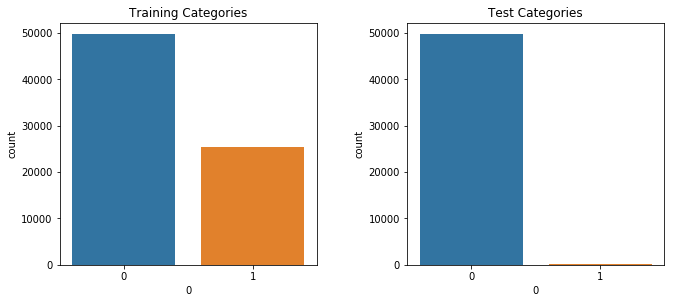

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1, 2, 1)
sns.countplot(line['0'])
plt.title('Training Categories')
plt.subplot(1,2,2)
sns.countplot(test_line['0'])
plt.title('Test Categories')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=1.5, hspace=0.25,
                    wspace=0.35)
plt.show()

In [46]:
filenames = tf.gfile.Glob(os.getcwd() + '/FInal_Numeric_Datsets/numeric_data_50k_*.csv')
test = tf.data.TextLineDataset(filenames).skip(1)
test.output_classes
check = test.map(parse_line)
#check

The Feature set is 968


<h6> Feature generation

In [95]:
INPUT_COLUMNS = []
for col in tot_cols:
    INPUT_COLUMNS.append(tf.feature_column.numeric_column(col))
    
def make_new_features(feats):
    ### Add new features if needed -- this makes more sense for the temporal columns 
    ### which I don't include here or if the features actually meant something physically. 
    ### Forget for now
    return feats


WIDE_COLUMNS = []
for col in wide_cols:
    WIDE_COLUMNS.append(tf.feature_column.numeric_column(col))
    

DEEP_COLUMNS = []
for col in deep_cols:
    DEEP_COLUMNS.append(tf.feature_column.numeric_column(col))

In [97]:
len(INPUT_COLUMNS), len(WIDE_COLUMNS) + len(DEEP_COLUMNS)

(968, 968)

<h5> Models: Define a DNN Classifier on Numerical inputs and experiment with a Wide and Deep Neural Network for Categorical and Numerical features

In [69]:
import shutil, os

if os.path.exists("./tmp/DNN_model"):
    shutil.rmtree("./tmp/DNN_model")
    model_dir = "./tmp/DNN_model"
else:
    model_dir = "./tmp/DNN_model"

In [108]:
if os.path.exists("./tmp/WDNN_model"):
    shutil.rmtree("./tmp/WDNN_model")
    model_wdnn_dir = "./tmp/WDNN_model"
else:
    model_wdnn_dir = "./tmp/WDNN_model"    

<h4> An issue with using Premade APIs is revealed below: the dataset is highly imbalanced. As you will see, the model 
    learns to put everything in the wrong category as that is the way to get the highest accuracy. I need to use either Custom Model to get the model to learn Recall or change the loss function

In [107]:
def models(model_dir, hidden_units = [128, 64, 32], dropout = 0.1, WDNN = False):
    ''' Builds a Regular DNN classifier or a Wide Deep Neural Network'''
    if not WDNN:
        classifier = tf.estimator.DNNClassifier(
        model_dir = model_dir,
        feature_columns=INPUT_COLUMNS,
        hidden_units=hidden_units,
        optimizer=tf.train.AdamOptimizer(1e-4),
        n_classes=2,
        loss_reduction=tf.losses.Reduction.MEAN,
        dropout=0.5,
        config=tf.estimator.RunConfig(tf_random_seed = 42))
        
    else:
        classifier = tf.estimator.DNNLinearCombinedClassifier(
        model_dir=model_wdnn_dir,
        linear_feature_columns=DEEP_COLUMNS,
        dnn_feature_columns=WIDE_COLUMNS,
        dnn_hidden_units=hidden_units,
        n_classes=2,
        loss_reduction=tf.losses.Reduction.MEAN,
        config=tf.estimator.RunConfig(tf_random_seed = 42))

    return classifier    
        
        

In [91]:
model = models(model_dir)

INFO:tensorflow:Using config: {'_model_dir': './tmp/DNN_model', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x14cd9d940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [71]:
start = time.time()
model.train(input_fn = get_train(), max_steps = 1000)
end = time.time()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./tmp/DNN_model/model.ckpt.
INFO:tensorflow:loss = 0.690138, step = 1
INFO:tensorflow:global_step/sec: 0.96803
INFO:tensorflow:loss = 0.6468393, step = 101 (103.304 sec)
INFO:tensorflow:global_step/sec: 1.04663
INFO:tensorflow:loss = 0.6135131, step = 201 (95.546 sec)
INFO:tensorflow:global_step/sec: 1.0435
INFO:tensorflow:loss = 0.59597564, step = 301 (95.830 sec)
INFO:tensorflow:global_step/sec: 1.03123
INFO:tensorflow:loss = 0.60129476, step = 401 (96.973 sec)
INFO:tensorflow:global_step/sec: 1.0407
INFO:tensorflow:loss = 0.5544534, step = 501 (96.087 sec)
INFO:tensorflow:global_step/sec: 1.05035
INFO:tensorflow:loss = 0.52832013, step = 601 (95.208 sec)
INFO:tensorflow:Saving checkpoints for 608 into ./t

In [79]:
(end-start)/60

16.29587483406067

<h4> Do some monitoring

<h4> Test the model on the test set

In [72]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, roc_curve, recall_score, precision_score, matthews_corrcoef

In [73]:
def calculate(prediction, LABEL):
    arr = {"accuracy": accuracy_score(LABEL, prediction),
           "Confusion_Matrix": confusion_matrix(LABEL, prediction),
           "F1 score": f1_score(LABEL,prediction),
           "Recall Score": recall_score(LABEL, prediction),
           "Precision Score": precision_score(LABEL, prediction)
           }
    return arr

In [74]:
def get_predictions(model, name, input_fn):
    y = model.predict(input_fn = input_fn)
    predictions = list(y)
    pred1=pd.DataFrame(data=predictions)
    prediction=pd.DataFrame(data=pred1['class_ids'])
    pred=[]
    for row in prediction["class_ids"]:
        pred.append(row[0])
    return pd.DataFrame(pred)

In [76]:
predicted_labels = get_predictions(model, 'Validation', get_valid())

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/DNN_model/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [77]:
# Read the test data in as a pandas dataframe and test the model.
labels = test_line['0']

In [78]:
predictions = calculate(predicted_labels, labels)
predictions

{'accuracy': 0.9512790255805116, 'Confusion_Matrix': array([[47333,  2399],
        [   37,   230]]), 'F1 score': 0.15883977900552487, 'Recall Score': 0.8614232209737828, 'Precision Score': 0.08748573602130087}

<h3> Wide and Deep Neural Network for a Max Steps = 10,000

In [109]:
model_wdnn = models(model_wdnn_dir, WDNN = True)
start = time.time()
model_wdnn.train(input_fn = get_train(), max_steps = 1000)
end = time.time()

INFO:tensorflow:Using config: {'_model_dir': './tmp/WDNN_model', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x18aac0400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_

In [110]:
predicted_labels = get_predictions(model_wdnn, 'Validation', get_valid())

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/WDNN_model/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [111]:
predictions = calculate(predicted_labels, labels)
predictions

{'accuracy': 0.994179883597672, 'Confusion_Matrix': array([[49708,    24],
        [  267,     0]]), 'F1 score': 0.0, 'Recall Score': 0.0, 'Precision Score': 0.0}